## Module3 Hand-on2

In [16]:
import pandas as pd
import numpy as np
import re
import string
from ordered_set import OrderedSet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from time import time
from scipy import sparse

import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tkthanatorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/tkthanatorn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def get_and_clean_data() -> pd.DataFrame:
    data = pd.read_csv("../../data/software_development_usa.csv")
    description = data["job_description"]
    cleaned_description = description.apply(
        lambda s: s.translate(str.maketrans("", "", string.punctuation + "\xa0"))
    )
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(
        lambda s: s.translate(
            str.maketrans(string.whitespace, " " * len(string.whitespace), "")
        )
    )
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

In [3]:
def create_stem_cache(cleaned_description:pd.DataFrame):
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)
    return stem_cache

In [4]:
def create_custom_processor(stop_dict: dict, stem_cache: dict):
    def custom_processor(s: str):
        ps = PorterStemmer()
        s = re.sub(r"[^A-Za-z]", " ", s)
        s = re.sub(r"\s+", " ", s)
        s = word_tokenize(s)
        s = list(OrderedSet(s) - stop_dict)
        s = [word for word in s if len(word) > 2]
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s]
        s = " ".join(s)
        return s
    return custom_processor

### `TF-IDF` from pages 39 - 42

In [5]:
arr = np.array([[100, 90, 5], [200, 200, 200], [200, 300, 10], [50, 0, 200]])
data = pd.DataFrame(
    arr,
    columns=["DevOpsHandbook", "ContinuousDelivery", "DistributedComputing"],
    index=["business", "computer", "git", "parallel"],
)
data = data.transpose()
data = np.log10(data + 1)

print(data.loc["DevOpsHandbook"].dot(data.loc["ContinuousDelivery"]))
print(data.loc["DevOpsHandbook"].dot(data.loc["DistributedComputing"]))
print(data.loc["ContinuousDelivery"].dot(data.loc["DistributedComputing"]))

14.93988519437762
13.195777686137447
9.410303606094942


In [6]:
data.loc["DevOpsHandbook"] /= np.sqrt((data.loc["DevOpsHandbook"] ** 2).sum())
data.loc["ContinuousDelivery"] /= np.sqrt((data.loc["ContinuousDelivery"] ** 2).sum())
data.loc["DistributedComputing"] /= np.sqrt((data.loc["DistributedComputing"] ** 2).sum())

print(data.to_markdown())

|                      |   business |   computer |      git |   parallel |
|:---------------------|-----------:|-----------:|---------:|-----------:|
| DevOpsHandbook       |   0.478543 |   0.549901 | 0.549901 |   0.407692 |
| ContinuousDelivery   |   0.501071 |   0.589096 | 0.633951 |   0        |
| DistributedComputing |   0.221882 |   0.656732 | 0.296942 |   0.656732 |


In [7]:
print(data.loc["DevOpsHandbook"].dot(data.loc["ContinuousDelivery"]))
print(data.loc["DevOpsHandbook"].dot(data.loc["DistributedComputing"]))
print(data.loc["ContinuousDelivery"].dot(data.loc["DistributedComputing"]))

0.9123394651809295
0.8983513789958275
0.6863034317623422


In [8]:
cleaned_description = get_and_clean_data()
cleaned_description = cleaned_description.iloc[:]
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words("english"))
my_custom_preprocessor = create_custom_processor(stop_dict, stem_cache)

In [9]:
vectorizer = TfidfVectorizer(preprocessor=my_custom_preprocessor, use_idf=True)
vectorizer.fit(cleaned_description)
transformed_data = vectorizer.transform(cleaned_description)
df = pd.DataFrame(transformed_data.toarray(), columns=vectorizer.get_feature_names_out())
max_term = df.sum().sort_values()[-10:].index
df[max_term].head(5)

,employ,respons,system,provid,test,design,requir,work,applic,develop
0,0.030353,0.026645,0.000000,0.028125,0.078244,0.046397,0.022774,0.020490,0.044218,0.057155
1,0.000000,0.038194,0.000000,0.000000,0.000000,0.033254,0.032645,0.029371,0.031692,0.054619
2,0.032782,0.000000,0.027089,0.030375,0.056336,0.000000,0.024596,0.044258,0.047755,0.041152
3,0.000000,0.000000,0.036995,0.041483,0.038469,0.000000,0.000000,0.030222,0.000000,0.056202
4,0.000000,0.038194,0.000000,0.000000,0.000000,0.033254,0.032645,0.029371,0.031692,0.054619


### Small workout from pages #43
> Compare the difference between `CounterVectorizer` and `TfidfVectorizer`

##### Based on the **entire document collection** and find 5 documents most relevant with the **Document** at row #0

In [10]:
query = [cleaned_description[0]]
query

['the chosen sr software developer will be part of a larger engineering team developing software for medical devices used within the orthopedic industry sr software developer will be responsible for designs codes and reviews software writes unit tests to demonstrate proper software functionality collaborates with software testers to ensure good test coverage resolve defects and mitigate safety hazards communicates with product management project managers technical writers and medical personnel design and implementation of feature development including identification of all tasks and the dependencies between tasks features and components provides technical expertise to architects analysts and other engineers as input for product design implementation and troubleshooting mentors junior engineers in software development best practices and testing methodologies via code and design review may participate in tool and library selections development environment improvements and process refinem

In [11]:
def counter_vectorize(
    texts: list[str],
    cleaned_description: pd.DataFrame,
    stop_dict: dict,
    stem_cache: dict,
):
    my_custom_preprocessor = create_custom_processor(stop_dict, stem_cache)
    vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
    vectorizer.fit(cleaned_description)

    base = vectorizer.transform(cleaned_description)
    base_df = pd.DataFrame(base.toarray(), columns=vectorizer.get_feature_names_out())

    query = vectorizer.transform(texts)
    query_df = pd.DataFrame(query.toarray(), columns=vectorizer.get_feature_names_out())

    dot_df = base_df.dot(query_df.transpose())
    indexes = dot_df.sort_values(ascending=False, by=0).iloc[1:6].index
    return cleaned_description.iloc[indexes]


start = time()
result = counter_vectorize(query, cleaned_description, stop_dict, stem_cache)
end = time()
print("Execution Time: {:2f}".format(end - start))
print(result.to_markdown())

Execution Time: 22.050348
|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [12]:
def tfidf_vectorize(
    texts: list[str],
    cleaned_description: pd.DataFrame,
    stop_dict: dict,
    stem_cache: dict,
):
    my_custom_preprocessor = create_custom_processor(stop_dict, stem_cache)
    vectorizer = TfidfVectorizer(preprocessor=my_custom_preprocessor, use_idf=True)
    vectorizer.fit(cleaned_description)

    base = vectorizer.transform(cleaned_description)
    base_df = pd.DataFrame(base.toarray(), columns=vectorizer.get_feature_names_out())

    query = vectorizer.transform(texts)
    query_df = pd.DataFrame(query.toarray(), columns=vectorizer.get_feature_names_out())

    dot_df = base_df.dot(query_df.transpose())
    indexes = dot_df.sort_values(ascending=False, by=0).iloc[1:6].index
    return cleaned_description.iloc[indexes]

start = time()
result = tfidf_vectorize(query, cleaned_description, stop_dict, stem_cache)
end = time()
print("Execution Time: {:2f}".format(end - start))
print(result.to_markdown())

Execution Time: 19.749640
|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

##### Use the entire document collection and find 5 document most relevant with the `aws devops`

In [13]:
query = ["aws devops"]
query

['aws devops']

In [14]:
start = time()
result = counter_vectorize(query, cleaned_description, stop_dict, stem_cache)
end = time()
print("Execution Time: {:2f}".format(end - start))
print(result.to_markdown())

Execution Time: 19.145792
|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [15]:
start = time()
result = tfidf_vectorize(query, cleaned_description, stop_dict, stem_cache)
end = time()
print("Execution Time: {:2f}".format(end - start))
print(result.to_markdown())

Execution Time: 20.769683
|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### TF-IDF from pages #22 - #39

In [17]:
X = vectorizer.transform(cleaned_description)
N = len(cleaned_description)

df = np.array((X.todense() > 0).sum(0))[0]
idf = np.log10(1 + (N / df))
tf = np.log10(X.todense() + 1)

tf_idf = np.multiply(tf, idf)

X = sparse.csr_matrix(tf_idf)
print(X.toarray())

X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

max_term = X_df.sum().sort_values()[-20:].sort_index().index
print(X_df[max_term].to_markdown())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
|      |      applic |     client |     custom |     design |    develop |   document |     employ |      engin |   implement |     integr |      manag |       oper |    perform |    product |    program |     provid |     requir |    respons |       test |       work |
|-----:|------------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|------------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
|    0 | 0.00641218  | 0.0176076  | 0          | 0.00699474 | 0.00734266 | 0          | 0.00591111 | 0.0116263  |  0.00640408 | 0          | 0.0101809  | 0          | 0          | 0.0056851  | 0.00514455 | 0.00508825 | 0.00341968 | 0.0045846  | 0.0128783  | 0.0028298  |
|    1 | 0.00462375  | 0.024863

### BM-25 from pages 80, 86 and 87

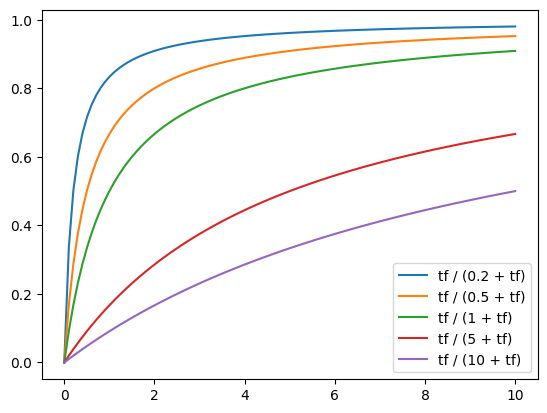

In [19]:
import matplotlib.pyplot as plt
tf = np.linspace(0, 10, 100)
for k in [.2, .5, 1, 5, 10]:
    plt.plot(tf, tf/(k+tf), label=f"tf / ({k} + tf)")
plt.legend()
plt.show()

In [20]:
class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1

    def fit(self, X):
        self.vectorizer.fit(X)
        self.y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avd1 = self.y.sum(1).mean()

    def transform(self, q):
        b, k1, avd1 = self.b, self.k1, self.avd1
        len_y = self.y.sum(1).A1
        (q,) = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avd1))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1
        numer = y.multiply(np.broadcast_to(idf, y.shape)) * (k1 + 1)
        return (numer / denom).sum(1).A1

In [21]:
bm25 = BM25(vectorizer)
bm25.fit(cleaned_description)
score = bm25.transform("aws devops")
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())

|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [22]:
score = bm25.transform("aws github")
rank = np.argsort(score)[::-1]
print(cleaned_description.iloc[rank[:5]].to_markdown())

|      | job_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                